In [1]:
#Sanitation and assertive programming
def add(a, b):
    try:
        a = float(a)
        b = float(b)
    except ValueError:
        raise ValueError("Input must be numbers")
    return a + b

The key here is to do some “sanitization” at the beginning of a function, so subsequently, we can assume the input is in a certain format. Not only do we have better confidence that our code works as expected, but it may also allow our main algorithm to be simpler because we ruled out some situations by sanitizing. To illustrate this idea, we can see how we can reimplement the built-in range() function:

In [2]:
def range(a, b=None, c=None):
    if c is None:
        c = 1
    if b is None:
        b = a
        a = 0
    values = []
    n = a
    while n < b:
        values.append(n)
        n = n + c
    return values

In [3]:
def evenitems(arr):
    newarr = []
    for i in range(len(arr)):
        if i % 2 == 0:
            newarr.append(arr[i])
    assert len(newarr) * 2 >= len(arr)
    return newar

While we develop this function, we are not sure our algorithm is correct. There are many things to check, but here we want to be sure that if we extracted every even-indexed item from the input, it should be at least half the length of the input array. When we try to optimize the algorithm or polish the code, this condition must not be invalidated. We keep the assert statement at strategic locations to make sure we didn’t break our code after modifications. You may consider this as a different way of unit testing. But usually, we call it unit testing when we check our functions’ input and output conformant to what we expect. Using assert this way is to check the steps inside a function.

If we write a complex algorithm, it is helpful to add assert to check for loop invariants, namely, the conditions that a loop should uphold.

In [4]:
def binary_search(array, target):
    """Binary search on array for target
 
    Args:
        array: sorted array
        target: the element to search for
    Returns:
        index n on the array such that array[n]==target
        if the target not found, return -1
    """
    s,e = 0, len(array)
    while s < e:
        m = (s+e)//2
        if array[m] == target:
            return m
        elif array[m] > target:
            e = m
        elif array[m] < target:
            s = m+1
        assert m != (s+e)//2, "we didn't move our midpoint"
    return -1

The last assert statement is to uphold our loop invariants. This is to make sure we didn’t make a mistake on the logic to update the start cursor s and end cursor e such that the midpoint m wouldn’t update in the next iteration. If we replaced s = m+1 with s = m in the last elif branch and used the function on certain targets that do not exist in the array, the assert statement will warn us about this bug. That’s why this technique can help us write better code.

It is amazing to see Python comes with a NotImplementedError exception built-in. This is useful for what we call  offensive programming.

In [5]:
import math
 
REGISTRY = {}
 
def register(name):
    def _decorator(fn):
        REGISTRY[name] = fn
        return fn
    return _decorator
 
@register("relu")
def rectified(x):
    return x if x > 0 else 0
 
@register("sigmoid")
def sigmoid(x):
    return 1/(1 + math.exp(-x))
 
def activate(x, funcname):
    if funcname not in REGISTRY:
        raise NotImplementedError(f"Function {funcname} is not implemented")
    else:
        func = REGISTRY[funcname]
        return func(x)
 
print(activate(1.23, "relu"))
print(activate(1.23, "sigmoid"))
print(activate(1.23, "tanh"))

1.23
0.7738185742694538


NotImplementedError: Function tanh is not implemented

As you can imagine, we can raise NotImplementedError in places where the condition is not entirely invalid, but it’s just that we are not ready to handle those cases yet. This is useful when we gradually develop our program, which we implement one case at a time and address some corner cases later. Having these guard rails in place will guarantee our half-baked code is never used in the way it is not supposed to. It is also a good practice to make our code harder to be misused, i.e., not to let variables go out of our intended range without notice.

Good Practices to Avoid Bugs

First is the use of the functional paradigm. While we know Python has constructs that allow us to write an algorithm in functional syntax, the principle behind functional programming is to make no side effect on function calls. We never mutate something, and we don’t use variables declared outside of the function. The “no side effect” principle is powerful in avoiding a lot of bugs since we can never mistakenly change something.

we should be careful if the argument to our function is a mutable object.


In [6]:
LOGS = []
 
def log(action):
    LOGS.append(action)
    
data = {"name": None}
for n in ["Alice", "Bob", "Charlie"]:
    data["name"] = n
    ...  # do something with `data`
    log(data)  # keep a record of what we did

This code intended to keep a log of what we did in the list LOGS, but it did not. While we work on the names “Alice,” “Bob,” and then “Charlie,” the three records in LOGS will all be “Charlie” because we keep the mutable dictionary object there. It should be corrected as follows:

In [7]:
import copy
 
def log(action):
    copied_action = copy.deepcopy(action)
    LOGS.append(copied_action)

The other technique to avoid bugs is not to reinvent the wheel. In Python, we have a lot of nice containers and optimized operations. You should never try to create a stack data structure yourself since a list supports append() and pop(). Your implementation would not be any faster. Similarly, if you need a queue, we have deque in the collections module from the standard library. Python doesn’t come with a balanced search tree or linked list. But the dictionary is highly optimized, and we should consider using the dictionary whenever possible. The same attitude applies to functions too. We have a JSON library, and we shouldn’t write our own. If we need some numerical algorithms, check if you can get one from NumPy.

Another way to avoid bugs is to use better logic. An algorithm with a lot of loops and branches would be hard to follow and may even confuse ourselves. It would be easier to spot errors if we could make our code clearer. For example, making a function that checks if the upper triangular part of a matrix contains any negative would be like this:

In [8]:
def neg_in_upper_tri(matrix):
    n_rows = len(matrix)
    n_cols = len(matrix[0])
    for i in range(n_rows):
        for j in range(n_cols):
            if i > j:
                continue  # we are not in upper triangular
            if matrix[i][j] < 0:
                return True
    return False

But we also use a Python generator to break this into two functions:

In [9]:
def get_upper_tri(matrix):
    n_rows = len(matrix)
    n_cols = len(matrix[0])
    for i in range(n_rows):
        for j in range(n_cols):
            if i > j:
                continue  # we are not in upper triangular
            yield matrix[i][j]
 
def neg_in_upper_tri(matrix):
    for element in get_upper_tri(matrix):
        if element[i][j] < 0:
            return True
    return False

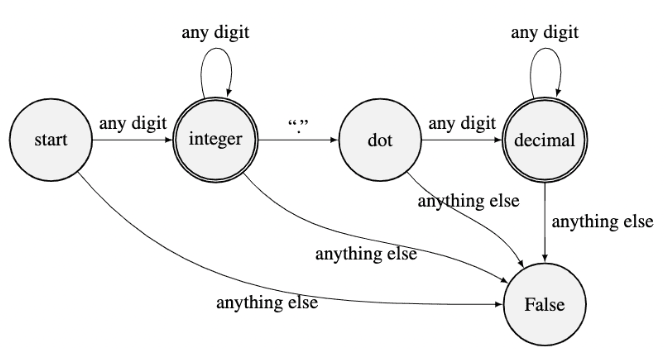

Let’s consider another example: We want to write a function to check if an input string looks like a valid floating point or integer. We require the string to be “0.12” and not accept “.12“. We need integers to be like “12” but not “12.“. We also do not accept scientific notations like “1.2e-1” or thousand separators like “1,234.56“. To make things simpler, we also do not consider signs such as “+1.23” or “-1.23“.

In [10]:
import re
 
def isfloat(floatstring):
    if not isinstance(floatstring, str):
        raise ValueError("Expects a string input")
    m = re.match(r"\d+(\.\d+)?$", floatstring)
    return m is not None
 
print(isfloat("foo"))       # False
print(isfloat(".3456"))     # False
print(isfloat("1.23"))      # True
print(isfloat("1..23"))     # False
print(isfloat("2"))         # True
print(isfloat("2."))        # False
print(isfloat("2,345.67"))  # False

False
False
True
False
True
False
False


https://medium.com/silicon-tribe-techdev/15-best-practices-every-python-developer-should-know-31122f1459f9

In [13]:
items = [4, 7, 18]
item1, item2, item3 = items
print(item2)

7


In [20]:
from collections import defaultdict
s = [('yellow', 'lamborghini'), ('blue', 'aston martin'), ('yellow', 'porsche'), ('blue', 'BMW'), ('red', 'Ferrari')]
d = defaultdict(list)
for k, v in s:
    d[k].append(v)
sorted(d.items())

[('blue', ['aston martin', 'BMW']),
 ('red', ['Ferrari']),
 ('yellow', ['lamborghini', 'porsche'])]

https://medium.com/@rajansahu713/learn-powerful-one-liners-in-python-ac2d2e6aa2fb